<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
pip install tensorflow_io

In [147]:
pip install fleep

  Preparing metadata (setup.py) ... done
  Created wheel for fleep: filename=fleep-1.0.1-py3-none-any.whl size=6106 sha256=d097dc1069aef27f26a4965c73754ff75eee958a1ffa7369e233a868f37015f5
  Stored in directory: /root/.cache/pip/wheels/98/75/ab/b791cc46a99c0b865f1abf77adcd5fea08fe2ca93fe7743f72
Successfully built fleep


In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [191]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_io as tfio
from scipy import ndimage

In [186]:
location = 'drive/MyDrive/bass samples/NBKoanbandstuff.wav'
audio = tfio.audio.AudioIOTensor(location)
audio = tf.squeeze(audio[:], axis=[1])

<function matplotlib.pyplot.show(close=None, block=None)>

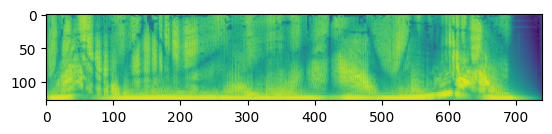

In [240]:
spectrogram = tfio.audio.spectrogram(audio, nfft=512*2, window=512, stride=256)
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=22000, mels=128, fmin=0, fmax=5000)
rotated_img = ndimage.rotate(mel_spectrogram, 90)
plt.imshow(tf.math.log(rotated_img))
plt.show


In [ ]:
def make_generator_model():

    input_noise = layers.Input(shape=(100,))
    input_digit = layers.Input(shape=(1,))
    digit = layers.Embedding(10, 10)(input_digit)
    digit = layers.Flatten()(digit)

    x = layers.concatenate([input_noise, digit])

    x = layers.Dense(8*8*64,activation='LeakyReLU')(x)

    x = layers.Reshape((8, 8, 64))(x)


    x = layers.Conv2DTranspose(64,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(64,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(3,3,1,padding='same',activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=(input_noise,input_digit), outputs=x)
    model.summary()
    return model


def make_discriminator_model():
    input_img = layers.Input(shape=(32,32,3))
    input_digit = layers.Input(shape=(1,))
    digit = layers.Embedding(10, 5)(input_digit)
    digit = layers.Flatten()(digit)

    x = layers.Conv2D(64, 5, 2, padding='same', activation='LeakyReLU', kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_img)


    x = layers.Conv2D(64, 3, 2, padding='same', activation='LeakyReLU', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)


    x = layers.Conv2D(64, 3, 2, padding='same', activation='LeakyReLU', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)


    x = layers.Conv2D(64, 3, 2, padding='same', activation='LeakyReLU', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    x = layers.Flatten()(x)

    x = layers.concatenate([x, digit])


    x = layers.Dense(128, activation='LeakyReLU', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)


    x = layers.Dense(64, activation='LeakyReLU', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)


    dense_output = layers.Dense(1, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = tf.keras.models.Model(inputs=(input_img, input_digit), outputs=dense_output)
    return model



In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
generator = make_generator_model()
generator_optimizer = tf.keras.optimizers.Adam(0.0004)

In [ ]:
discriminatorU = make_discriminator_model()
discriminatorU_optimizer = tf.keras.optimizers.Adam(0.0004)

In [ ]:

@tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss



@tf.function
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

In [ ]:
NOISE_DIM = 100
BATCH_SIZE = 64
#@tf.function
def train_step(real_images,digits):

    for i in range(5):
      with tf.GradientTape() as disc_tape:
        # Generate random noise
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

        # Generate fake images with the generator
        generated_images = generator((noise,digits), training=True)

        # Discriminator loss calculation
        real_output = discriminatorU((real_images,digits), training=True)
        fake_output = discriminatorU((generated_images,digits), training=True)
        d_loss = discriminator_loss(real_output, fake_output,)


      gradients_of_discriminator = disc_tape.gradient(d_loss, discriminatorU.trainable_variables)
      discriminatorU_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminatorU.trainable_variables))

      if i == 0:
        weights = discriminatorU.get_weights()

    with tf.GradientTape() as gen_tape:
      # Generate random noise
      noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

      # Generate fake images with the generator
      generated_images = generator((noise,digits), training=True)

      fake_output = discriminatorU((generated_images,digits), training=True)

       # Generator loss calculation
      g_loss = generator_loss(fake_output)

    # Update generator and discriminator variables


    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    discriminatorU.set_weights(weights)

    tf.print("disc_loss",d_loss,'gen_loss',g_loss)





In [ ]:
def train(dataset,y_train, epochs):
  for epoch in range(epochs):
    for batch in range(len(dataset) // BATCH_SIZE):

            target_images = dataset[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]
            digits = y_train[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]

            train_step(target_images,digits)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print(epoch)



In [ ]:
EPOCHS = 100
x_train2 = np.expand_dims(x_train, axis=-1)
x_train2 = (x_train2 - np.min(x_train2)) / (np.max(x_train2) - np.min(x_train2))
train(x_train2,y_train, EPOCHS)

In [ ]:
noise = tf.random.normal(shape=(1,100))
random_number = tf.random.uniform(shape=[1,], minval=0, maxval=10, dtype=tf.int32)
test = generator.predict((noise,random_number))
print(random_number)
plt.imshow(test.squeeze())
plt.show()